In [3]:
from dataclasses import dataclass
from enum import Enum
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sortedcontainers import SortedDict
import random

def BSMPath(S_0: float, r: float, sigma: float, T: float, N: int, rng: np.random.Generator):
    delta = T / N
    Z = rng.normal(loc=0, scale=1, size=(N))
    path = np.empty((N + 1), dtype=np.float64)
    path[0] = S_0
    for i in range(N):
        path[i + 1] = path[i] * np.exp((r - 0.5 * np.power(sigma, 2.0)) * delta + sigma * np.sqrt(delta) * Z[i])
    return path

@dataclass
class LimitOrder:
    price: float
    timestamp: float
    quantity: float
    id: int
    
    def __repr__(self):
        return f"Order(id={self.id}, price={self.price}, quantity={self.quantity}, ts={self.timestamp})"
    
    def tuplify(self) -> Tuple[float, float, float, int]:
        return (self.price, self.timestamp, self.quantity, self.id)
    
    @staticmethod
    def detuplify(tup: Tuple[float, float, float, int]):
        return LimitOrder(price=tup[0], timestamp=tup[1], quantity=tup[2], id=tuple[3])

@dataclass
class Transaction:
    price: float
    quantity: float

class CLOB:
    _bid_queue: SortedDict
    _ask_queue: SortedDict
    _bid_dict: dict[int, Tuple[float, float]]
    _ask_dict: dict[int, Tuple[float, float]]
    
    def _key(self, order: LimitOrder):
        return (order.price, order.timestamp)
    
    def __init__(self):
        self._bid_queue = SortedDict(lambda k: (-k[0], k[1]))
        self._ask_queue = SortedDict(lambda k: (k[0], k[1]))
        self._bid_dict = {}
        self._ask_dict = {}
        
    def submit_bid(self, order: LimitOrder):
        key = self._key(order)
        self._bid_queue[key] = order
        self._bid_dict[order.id] = key
    
    def submit_ask(self, order: LimitOrder):
        key = self._key(order)
        self._ask_queue[key] = order
        self._ask_dict[order.id] = key
        
    def get_all_bid_ids(self):
        return [x.id for x in self._bid_queue.values()]    
    
    def get_all_ask_ids(self):
        return [x.id for x in self._ask_queue.values()]
        
    def cancel_bid(self, id: int):
        key = self._bid_dict[id]
        self._bid_queue.pop(key)
    
    def cancel_ask(self, id: int):
        key = self._ask_dict[id]
        self._ask_queue.pop(key)
        
    def _remove_top_bid(self):
        kv = self._bid_queue.popitem(0)
        order = kv[1]
        self._bid_dict.pop(order.id)
        
    def _remove_top_ask(self):
        kv = self._ask_queue.popitem(0)
        order = kv[1]
        self._ask_dict.pop(order.id)
        
    def top_bid(self) -> LimitOrder|None:
        length = len(self._bid_queue)
        if length == 0:
            return None
        return self._bid_queue.peekitem(0)[1]
    
    def top_ask(self) -> LimitOrder|None:
        length = len(self._ask_queue)
        if length == 0:
            return None
        return self._ask_queue.peekitem(0)[1]
        
    def process_transactions(self):
        transactions: List[Transaction] = []
        while True:
            bid = self.top_bid()
            ask = self.top_ask()
            if bid != None and ask != None:
                if bid.price >= ask.price:
                    transacted_price = ask.price
                    transacted_quantity = min(bid.quantity, ask.quantity)
                    resulting_bid_quantity = bid.quantity - transacted_quantity
                    resulting_ask_quantity = ask.quantity - transacted_quantity
                    if resulting_bid_quantity == 0:
                        self._remove_top_bid()
                    else:
                        bid.quantity = resulting_bid_quantity
                    
                    if resulting_ask_quantity == 0:
                        self._remove_top_ask()
                    else:
                        ask.quantity = resulting_ask_quantity
                    
                    transactions.append(Transaction(price=transacted_price, quantity=transacted_quantity))
                else:
                    break
            else:
                break
        return transactions
        
    def get_cumulative_depth(self):
        bid_depth: dict[float, float] = {}
        ask_depth: dict[float, float] = {}
        
        cumulative_bid_depth = 0
        for n in self._bid_queue.values():
            order: LimitOrder = n
            cumulative_bid_depth += order.quantity
            bid_depth[order.price] = cumulative_bid_depth
            
        cumulative_ask_depth = 0
        for n in self._ask_queue.values():
            order: LimitOrder = n
            cumulative_ask_depth += order.quantity
            ask_depth[order.price] = cumulative_ask_depth
        
        return bid_depth, ask_depth

C:\Users\Emu\AppData\Local\Temp\ipykernel_25000\4186881066.py:132: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax4.set_ylim(0, max(rolling_volatility, default=0.01))  # Adjust dynamically


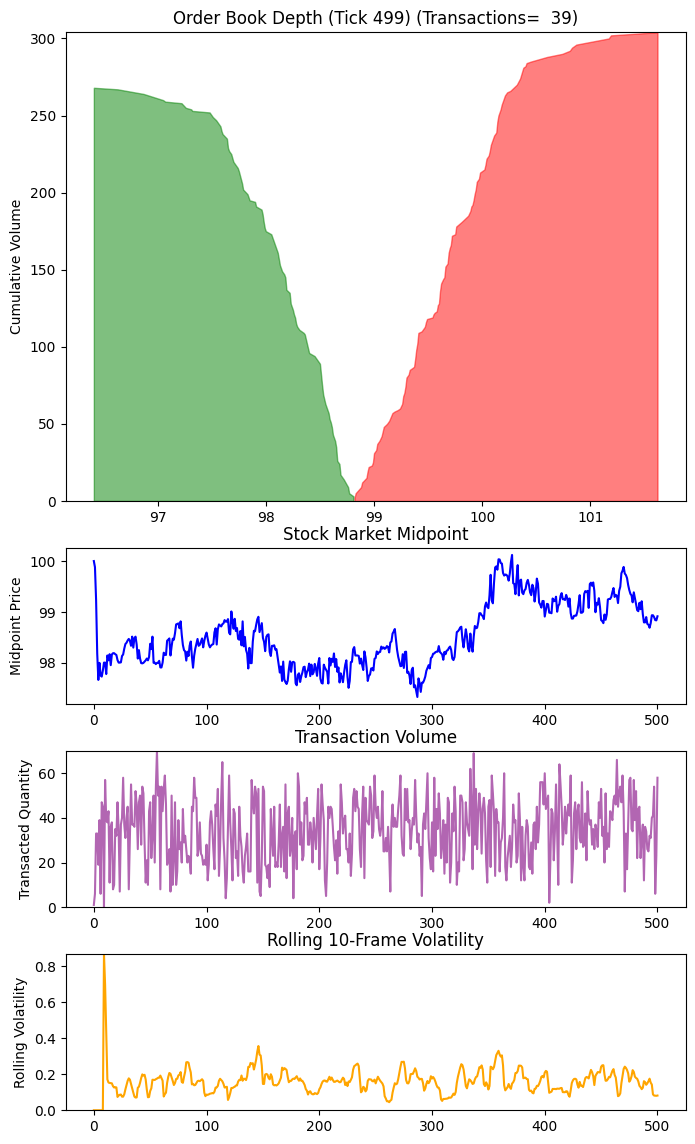

In [4]:
clob = CLOB()

bid_prices = [99.0, 98.0, 97.0, 96.0]
ask_prices = [101.0, 102.0, 103.0, 104.0]

for i, price in enumerate(bid_prices):
    id = + np.random.randint(0, 999_999_999)
    timestamp = (i + 1) / len(bid_prices)
    clob.submit_bid(LimitOrder(price=price, timestamp=timestamp, quantity=np.random.randint(1, 5), id=id))

for i, price in enumerate(ask_prices):
    id = + np.random.randint(0, 999_999_999)
    timestamp = (i + 1) / len(ask_prices)
    clob.submit_ask(LimitOrder(price=price, timestamp=timestamp, quantity=np.random.randint(1, 5), id=id))

# Set up the figure and axis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 14), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
ax1.set_xlim(85, 110)  # Adjust price range based on expected bid/ask prices
ax1.set_xlabel("Price")
ax1.set_ylabel("Cumulative Volume")
ax1.set_title("Order Book Depth")

ax2.set_xlabel("Frame")
ax2.set_ylabel("Midpoint Price")
ax2.set_title("Stock Market Midpoint")

ax3.set_xlabel("Frame")
ax3.set_ylabel("Transacted Quantity")
ax3.set_title("Transaction Volume Histogram")

ax4.set_xlabel("Frame")
ax4.set_ylabel("Rolling Volatility")
ax4.set_title("Rolling 10-Frame Volatility")

# Initial empty plot
bid_area = ax1.fill_between([], [], color='green', alpha=0.5)
ask_area = ax1.fill_between([], [], color='red', alpha=0.5)
midpoint_prices: List[float] = []
transaction_volumes: List[float] = []
rolling_volatility: List[float] = []

def compute_volatility(prices: List[float], window=10):
    if len(prices) < window:
        return 0.0
    return np.std(prices[-window:])

# Function to update animation frame
def update(frame: int, clob: CLOB, T: float, N: int):    
    # Remove 10% of all bids and asks
    bid_ids = clob.get_all_bid_ids()
    bids_to_remove = random.sample(bid_ids, k=len(bid_ids) // 10)
    for bid_id in bids_to_remove:
        clob.cancel_bid(bid_id)
        
    ask_ids = clob.get_all_ask_ids()
    asks_to_remove = random.sample(ask_ids, k=len(ask_ids) // 10)
    for ask_id in asks_to_remove:
        clob.cancel_ask(ask_id)
    
    top_bid = clob.top_bid() 
    top_ask = clob.top_ask()
    
    MAX_BID_COUNT = 50
    MAX_ASK_COUNT = 50
    delta = T / N
    r = 0.2
    sigma = 0.2

    if top_bid and top_ask:
        midpoint = (top_bid.price + top_ask.price) / 2
        midpoint_prices.append(midpoint)
        rolling_volatility.append(compute_volatility(midpoint_prices))
        
        bid_count = np.random.randint(0, MAX_BID_COUNT)
        bid_Z = np.random.normal(loc=0, scale=1.0, size=bid_count)
        bid_prices = top_bid.price * np.exp(r * delta + sigma * np.sqrt(delta) * bid_Z)
        bid_volumes = np.random.randint(1, 5, size=bid_count)
        
        ask_count = np.random.randint(0, MAX_ASK_COUNT)
        ask_Z = np.random.normal(loc=0, scale=1.0, size=ask_count)
        ask_prices = top_ask.price * np.exp(r * delta + sigma * np.sqrt(delta) * ask_Z)
        ask_volumes = np.random.randint(1, 5, size=ask_count)
        
        action_count = 0
        
        for j in range(bid_count):
            action_count += 1
            timestamp = frame + (j + 1) / bid_count
            id = np.random.randint(0, 999_999_999)
            clob.submit_bid(LimitOrder(price=round(bid_prices[j], 2), timestamp=timestamp, quantity=bid_volumes[j], id=id))
            
        for j in range(ask_count):
            action_count += 1
            timestamp = frame + (j + 1) / ask_count
            id = np.random.randint(0, 999_999_999)
            clob.submit_ask(LimitOrder(price=round(ask_prices[j], 2), timestamp=timestamp, quantity=ask_volumes[j], id=id))
        
        transactions = clob.process_transactions()
        depths = clob.get_cumulative_depth()
        
        transaction_quantity = sum(t.quantity for t in transactions)
        transaction_volumes.append(transaction_quantity)
        
        bid_prices = list(depths[0].keys())
        bid_volumes = list(depths[0].values())
        ask_prices = list(depths[1].keys())
        ask_volumes = list(depths[1].values())
        
        ax1.clear()
        ax1.fill_between(bid_prices, bid_volumes, color='green', alpha=0.5)
        ax1.fill_between(ask_prices, ask_volumes, color='red', alpha=0.5)
        # ax1.set_xlim(85, 110)
        ax1.set_ylim(0, max(bid_volumes + ask_volumes, default=50))  # Adjust dynamically
        ax1.set_ylabel("Cumulative Volume")
        ax1.set_title(f"Order Book Depth (Tick {frame}) (Transactions={len(transactions):4})")
        
        ax2.clear()
        ax2.plot(midpoint_prices, color='blue')
        ax2.set_ylabel("Midpoint Price")
        ax2.set_title("Stock Market Midpoint")
        
        ax3.clear()
        ax3.plot(range(len(transaction_volumes)), transaction_volumes, color='purple', alpha=0.6)
        ax3.set_ylabel("Transacted Quantity")
        ax3.set_title("Transaction Volume")
        ax3.set_ylim(0, max(transaction_volumes, default=10))  # Adjust dynamically
        
        ax4.clear()
        ax4.plot(rolling_volatility, color='orange')
        ax4.set_ylabel("Rolling Volatility")
        ax4.set_title("Rolling 10-Frame Volatility")
        ax4.set_ylim(0, max(rolling_volatility, default=0.01))  # Adjust dynamically

N = 500
# Create animation
ani = animation.FuncAnimation(
    fig, lambda f: update(f, clob, 1.0, N), frames=N, repeat=False, 
)
ani.save("CLOB_2.demo.mp4", fps=30, extra_args=['-vcodec', 'libx264'])

# Display animation
plt.show()